### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [1]:
!curl -sLo loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
!curl -sLo loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

In [2]:
from itertools import product

from pathlib import Path
from typing import (List, Tuple, Union)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from pandas import DataFrame, Series
from numpy import ndarray

import matplotlib.ticker as ticker
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, StandardScaler)
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# In binary and multiclass classification, accuracy_score
# is equal to the jaccard_score function.
from sklearn.metrics import (
    accuracy_score,
    jaccard_score,
    f1_score,
    log_loss
)

%load_ext watermark
%watermark -dvtp sklearn,numpy,pandas,matplotlib,seaborn

2020-07-30 16:07:59 

CPython 3.8.3
IPython 7.14.0

sklearn 0.0
numpy 1.19.1
pandas 1.1.0
matplotlib 3.3.0
seaborn 0.10.1


In [3]:
# Ignore DataConversionWarning from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Load Data From CSV File  

In [4]:
df = pd.read_csv(
    'loan_train.csv',
    parse_dates=['due_date', 'effective_date'],
    dtype={
        'loan_status': 'category',
        'education': 'category',
        'Gender': 'category',
    },
    usecols=lambda x: "Unnamed" not in x)
# Make all columns names to lower case
df.columns = df.columns.str.lower()
df.head()

,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     346 non-null    category      
 1   principal       346 non-null    int64         
 2   terms           346 non-null    int64         
 3   effective_date  346 non-null    datetime64[ns]
 4   due_date        346 non-null    datetime64[ns]
 5   age             346 non-null    int64         
 6   education       346 non-null    category      
 7   gender          346 non-null    category      
dtypes: category(3), datetime64[ns](2), int64(3)
memory usage: 15.0 KB


In [6]:
path = Union[str, Path]

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, weekend_on: int = 3):
        self.weekend_on = weekend_on
    def fit(self, X: DataFrame, y=None) -> 'DataFrameSelector':
        return self
    def transform(self, X: DataFrame) -> ndarray:
        attributes: List[str] = ['principal', 'terms', 'age', 'gender', 'education']
        # Include new feature 'loan at end of the week' 
        X: DataFrame = X.copy()
        dayofweek: Series = X['effective_date'].dt.dayofweek
        X['weekend'] = dayofweek.apply(lambda x: 1 if (x>3)  else 0)  # (dayofweek >= weekend_on).astype(int) 
        X['gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

        features: DataFrame = X[attributes + ['weekend']]

        encoded_features: DataFrame = pd.get_dummies(features).select_dtypes(exclude=['category'])
        return encoded_features.values

def read_csv(p: path) -> DataFrame:
    df = pd.read_csv(
        p,
        parse_dates=['due_date', 'effective_date'],
        dtype={
            'loan_status': 'category',
            'education': 'category',
            'Gender': 'category',
        },
        usecols=lambda x: "Unnamed" not in x)
    
    df.columns = df.columns.str.lower()  # Make all columns names to lower case

    return df

# Classification 

In [7]:
df_train = read_csv('./loan_train.csv')
df_test = read_csv('./loan_test.csv')

In [8]:
y_encoder = LabelEncoder()
y_encoder.fit(df_train['loan_status'].values)
y_train = y_encoder.transform(df_train['loan_status'].values)
y_test = y_encoder.transform(df_test['loan_status'].values)

# K Nearest Neighbor(KNN)

## K Nearest Neighbor(KNN): find best K by train/test split

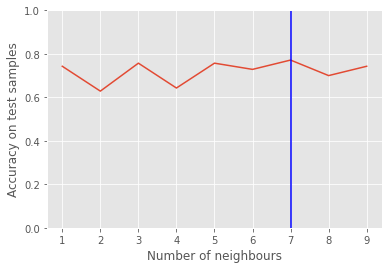

In [9]:
_X_train, _X_test, _y_train, _y_test = train_test_split(
    df_train,
    df_train['loan_status'].values,
    test_size=0.2,
    random_state=42
)

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1)
    x = range(1,10)
    y = [np.mean(_y_test == Pipeline(steps=[
            ('selector', DataFrameSelector()),
            ('std_scaler', StandardScaler()),
            ('knc', KNeighborsClassifier(n_neighbors=n))
            ]) \
          .fit(_X_train, _y_train) \
          .predict(_X_test)) 
         for n in x]
    ax.plot(x, y)
    ax.set(ylim=[0, 1], xlabel='Number of neighbours', ylabel='Accuracy on test samples')
    ax.axvline(np.argmax(y)+1, c='blue')
    plt.show()

**7** seems to be the best coefficient with this random seed. Let's try a GridSearchCV

## K Nearest Neighbor(KNN): GridSearchCV¶

In [10]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'knc__n_neighbors': np.arange(1, 10),
}

knn_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(weekend_on=4)),
    ('std_scaler', StandardScaler()),
    ('knc', KNeighborsClassifier(n_neighbors=4))
])

search = GridSearchCV(knn_pipeline, param_grid, cv=3, n_jobs=-1)
search.fit(df_train, y_train)

knn_pipeline = estimator = search.best_estimator_

print(estimator)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
# In binary and multiclass classification, accuracy_score
# is equal to the jaccard_score function.
print("Train set Accuracy: ", accuracy_score(y_train, estimator.predict(df_train)))

y_hat = estimator.predict(df_test)
print("Jaccard similarity score: ", jaccard_score(y_test, y_hat))
print("F1-score: ", f1_score(y_test, y_hat, average='weighted'))

Pipeline(steps=[('selector', DataFrameSelector(weekend_on=4)),
                ('std_scaler', StandardScaler()),
                ('knc', KNeighborsClassifier())])
Best parameter (CV score=0.703):
Train set Accuracy:  0.815028901734104
Jaccard similarity score:  0.7
F1-score:  0.7001989201477693


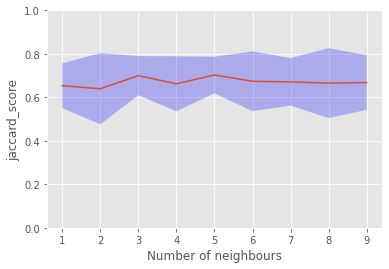

In [11]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1)
    x = [_res['knc__n_neighbors'] for _res in search.cv_results_['params']]
    y_mean = search.cv_results_['mean_test_score']
    sigma = search.cv_results_['std_test_score']
    ax.plot(x, y_mean)
    ax.fill_between(x, y_mean - sigma, y_mean + sigma, facecolor ='blue', alpha = 0.25)
    ax.set(ylim=[0, 1], xlabel='Number of neighbours', ylabel='jaccard_score')
    plt.show()

Not convinced by 7 as an optimum!, but let's take 7

In [12]:
knn_pipeline = Pipeline(steps=[
                    ('selector', DataFrameSelector()),
                    ('std_scaler', StandardScaler()),
                    ('knc', KNeighborsClassifier(n_neighbors=7))
                    ]) \
               .fit(df_train, y_train) 

# Decision Tree

I'm using a `DecisionTreeClassifier(criterion="entropy", max_depth=1)` model. THe GridSearchCV finds the best `max_depth` by itself

In [13]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'dt__max_depth': range(1, 10)
}

dt_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(weekend_on=4)),
    ('std_scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(criterion="entropy", max_depth=1))
])

search = GridSearchCV(dt_pipeline, param_grid, cv=3, n_jobs=-1)
search.fit(df_train, y_train)

dt_pipeline = estimator = search.best_estimator_

print(estimator)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
# In binary and multiclass classification, accuracy_score
# is equal to the jaccard_score function.
print("Train set Accuracy: ", accuracy_score(y_train, estimator.predict(df_train)))

y_hat = estimator.predict(df_test)
print("Jaccard similarity score: ", jaccard_score(y_test, y_hat))
print("F1-score: ", f1_score(y_test, y_hat, average='weighted'))

Pipeline(steps=[('selector', DataFrameSelector(weekend_on=4)),
                ('std_scaler', StandardScaler()),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])
Best parameter (CV score=0.674):
Train set Accuracy:  0.7514450867052023
Jaccard similarity score:  0.7407407407407407
F1-score:  0.6304176516942475


# Support Vector Machine

In [14]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'svc__C': np.linspace(1, 3, 10),
}

svc_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(weekend_on=4)),
    ('std_scaler', StandardScaler()),
    ('svc', SVC(C=0.01, kernel='rbf'))
])

search = GridSearchCV(svc_pipeline, param_grid, cv=3, n_jobs=-1)
search.fit(df_train.copy(), y_train.copy())

svc_pipeline = estimator = search.best_estimator_

print(estimator)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
# In binary and multiclass classification, accuracy_score
# is equal to the jaccard_score function.
print("Train set Accuracy: ", accuracy_score(y_train, estimator.predict(df_train)))

y_hat = estimator.predict(df_test)
print("Jaccard similarity score: ", jaccard_score(y_test, y_hat))
print("F1-score: ", f1_score(y_test, y_hat, average='weighted', labels=np.unique(y_hat)))

Pipeline(steps=[('selector', DataFrameSelector(weekend_on=4)),
                ('std_scaler', StandardScaler()),
                ('svc', SVC(C=1.2222222222222223))])
Best parameter (CV score=0.674):
Train set Accuracy:  0.7774566473988439
Jaccard similarity score:  0.7222222222222222
F1-score:  0.6212664277180406


# Logistic Regression

In [15]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'lr__C': np.linspace(0.01, 1, 10),
    'lr__tol': np.linspace(0.0001, 0.001, 10),
}

lr_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(weekend_on=4)),
    ('std_scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='lbfgs'))
])

search = GridSearchCV(lr_pipeline, param_grid, cv=3, n_jobs=-1)
search.fit(df_train, y_train)

lr_pipeline = estimator = search.best_estimator_

print("Best parameter (CV score=%0.3f):" % search.best_score_)
# In binary and multiclass classification, accuracy_score
# is equal to the jaccard_score function.
print("Train set Accuracy: ", accuracy_score(y_train, estimator.predict(df_train)))


y_hat = estimator.predict(df_test)
y_hat_prob = estimator.predict_proba(df_test)
print("Jaccard similarity score: ", jaccard_score(y_test, y_hat))
print("F1-score: ", f1_score(y_test, y_hat, average='weighted', labels=np.unique(y_hat)))
print("Log-loss: ", log_loss(y_test, y_hat_prob))

Best parameter (CV score=0.749):
Train set Accuracy:  0.7514450867052023
Jaccard similarity score:  0.7407407407407407
F1-score:  0.851063829787234
Log-loss:  0.5190440232613492


# Model Evaluation using Test set

In [16]:
df_test = read_csv('./loan_test.csv')
y_test = y_encoder.transform(df_test['loan_status'].values)

## KNN

In [17]:
y_hat = knn_pipeline.predict(df_test)
print(f"Jaccard score: {jaccard_score(y_test, y_hat):.2f}")
print(f"F1-score: {f1_score(y_test, y_hat, average='weighted'):.2f}")

Jaccard score: 0.71
F1-score: 0.67


## Decision Tree

In [18]:
y_hat = dt_pipeline.predict(df_test)
print(f"Jaccard score: {jaccard_score(y_test, y_hat):.2f}")
print(f"F1-score: {f1_score(y_test, y_hat, average='weighted'):.2f}")

Jaccard score: 0.74
F1-score: 0.63


## Logistic Regression

In [19]:
y_hat = lr_pipeline.predict(df_test)
print(f"Jaccard score: {jaccard_score(y_test, y_hat):.2f}")
print(f"F1-score: {f1_score(y_test, y_hat, average='weighted'):.2f}")
y_hat_prob = lr_pipeline.predict_proba(df_test)
print(f"LogLoss: {log_loss(y_test, y_hat_prob):.2f}")

Jaccard score: 0.74
F1-score: 0.63
LogLoss: 0.52


## SVM

In [20]:
y_hat = svc_pipeline.predict(df_test)
print(f"Jaccard score: {jaccard_score(y_test, y_hat):.2f}")
print(f"F1-score: {f1_score(y_test, y_hat, average='weighted'):.2f}")

Jaccard score: 0.72
F1-score: 0.62


# Report

In [21]:
pipelines = {
    'KNN': knn_pipeline,
    'Decision Tree': dt_pipeline,
    'SVM': svc_pipeline,
    'Log. reg.': lr_pipeline
}
metrics = {
    'Jaccard': jaccard_score,
    'F1-score': f1_score,
    'LogLoss': log_loss
}
results = DataFrame(columns=list(metrics), index=list(pipelines))


y_hat = None

for _p in pipelines:
    y_hat = pipelines[_p].predict(df_test)
    y_hat_prob = (_p == 'Log. reg.') and pipelines[_p].predict_proba(df_test)
    
    results.loc[_p, 'Jaccard'] = jaccard_score(y_test, y_hat)
    results.loc[_p, 'F1-score'] = f1_score(y_test, y_hat, average='weighted')
    results.loc[_p, 'LogLoss'] = log_loss(y_test, y_hat_prob) if _p == 'Log. reg.' else np.NaN

results.astype(float).round(2)

,Jaccard,F1-score,LogLoss
KNN,0.71,0.67,NaN
Decision Tree,0.74,0.63,NaN
SVM,0.72,0.62,NaN
Log. reg.,0.74,0.63,0.52


**Results are impacted by the small number of samples while using a GridSearchCV**